# Classificação de Raças

### Importing libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pathlib as pl
import cv2
import numpy as np

### Loading the data

In [2]:
from zipfile import ZipFile

# ajuste o path de acordo com a localizacao do dataset
data_path = '/content/drive/MyDrive/CIS/Dog_breed_classification/data.zip'

with ZipFile(data_path, 'r') as zip:
    zip.extractall()

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Caminho para a pasta com as imagens originais
base_path = "/content/data"
output_path = "stanford-dogs-dataset-split/"
train_folder = os.path.join(output_path, "train")
test_folder = os.path.join(output_path, "test")

# Criando as pastas de saída
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Iterar sobre os subdiretórios de raças
for breed in os.listdir(base_path):
    breed_path = os.path.join(base_path, breed)
    if os.path.isdir(breed_path):  # Verifica se é uma pasta
        images = [img for img in os.listdir(breed_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Divide as imagens em treino e teste (80%-20%)
        train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

        # Criando as pastas específicas para cada raça
        train_breed_folder = os.path.join(train_folder, breed)
        test_breed_folder = os.path.join(test_folder, breed)
        os.makedirs(train_breed_folder, exist_ok=True)
        os.makedirs(test_breed_folder, exist_ok=True)

        # Movendo os arquivos para treino
        for img in train_images:
            shutil.copy(os.path.join(breed_path, img), os.path.join(train_breed_folder, img))

        # Movendo os arquivos para teste
        for img in test_images:
            shutil.copy(os.path.join(breed_path, img), os.path.join(test_breed_folder, img))

In [ ]:
train_dir = os.path.join(output_path, 'train')
test_dir = os.path.join(output_path, 'test')

BATCH_SIZE = 32
IMG_SIZE = (224, 224)

# lendo o dataset de treino e teste
train_ds = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                      shuffle=True,
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMG_SIZE,
                                                      labels="inferred")

test_ds = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                      shuffle=True,
                                                      batch_size=BATCH_SIZE,
                                                      image_size=IMG_SIZE,
                                                      labels="inferred")

Found 16418 files belonging to 120 classes.
Found 4162 files belonging to 120 classes.


### Building the model

In [ ]:
base_model = keras.applications.ResNet50(input_shape=(IMG_SIZE + (3,)),
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
# Frizando as camadas do modelo
base_model.trainable = False

base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Pegando um batch de imagens
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [ ]:
# adicionando uma camada de pooling 2D
global_average_layer = keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(image_batch)

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
# x = data_augmentation(inputs)
# x = preprocess_input(inputs)
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
# prediction layer
outputs = keras.layers.Dense(120, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.01

sgd = keras.optimizers.SGD(learning_rate=base_learning_rate, clipnorm=1, decay=1e-6,
          momentum = 0.9, nesterov=True)
model.compile(optimizer=sgd, loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
checkpointer = keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/CIS/Dog_breed_classification/transfer_learning_model.keras',
                                                monitor="val_accuracy", verbose=1, save_best_only=True)

In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 120)                 │         245,880 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,833,592 (90.92 MB)

 Trainable params: 245,880 (960.47 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = model.fit(train_ds,
          validation_data=test_ds,
          epochs=10,
          batch_size=32,
          callbacks=[checkpointer],
          verbose=1,
          shuffle=True)

Epoch 1/10
514/514 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - accuracy: 0.1512 - loss: 4.0944
Epoch 1: val_accuracy improved from -inf to 0.50096, saving model to /content/drive/MyDrive/CIS/Dog_breed_classification/transfer_learning_model.keras
514/514 ━━━━━━━━━━━━━━━━━━━━ 90s 140ms/step - accuracy: 0.1514 - loss: 4.0925 - val_accuracy: 0.5010 - val_loss: 1.9018
Epoch 2/10
513/514 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5070 - loss: 1.8454
Epoch 2: val_accuracy improved from 0.50096 to 0.57568, saving model to /content/drive/MyDrive/CIS/Dog_breed_classification/transfer_learning_model.keras
514/514 ━━━━━━━━━━━━━━━━━━━━ 63s 111ms/step - accuracy: 0.5071 - loss: 1.8450 - val_accuracy: 0.5757 - val_loss: 1.5382
Epoch 3/10
513/514 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.5968 - loss: 1.4449
Epoch 3: val_accuracy improved from 0.57568 to 0.60235, saving model to /content/drive/MyDrive/CIS/Dog_breed_classification/transfer_learning_model.keras
514/514 ━━━━━━━━━━━━━━━━━━━━ 91s 129ms/s

In [ ]:
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


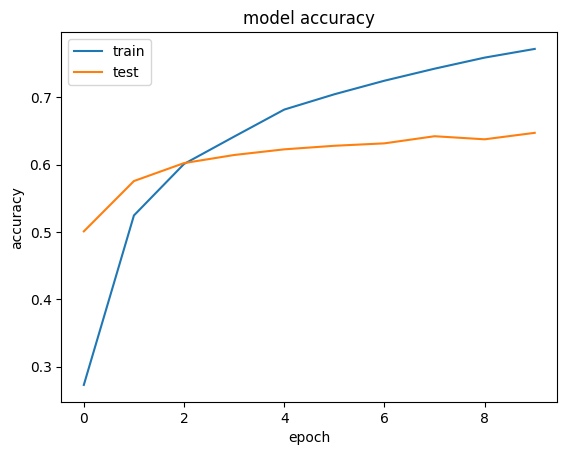

In [ ]:
# Plota o gráfico da acurácia do modelo
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

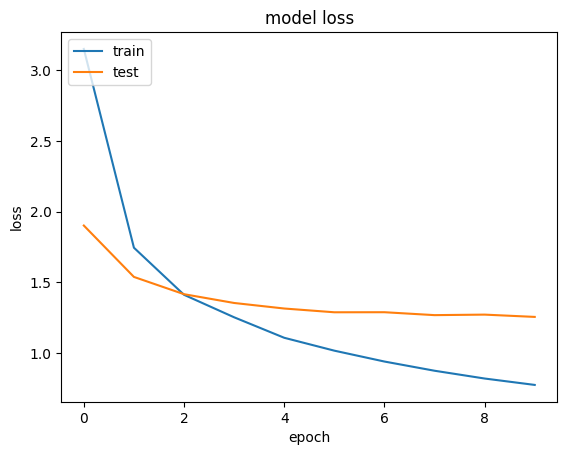

In [ ]:
# Gráfico da função de custo
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
model.save("transfer_learning_model.keras")